# Facial Keypoint Detection by modest Neural Networks, shaped using insight


> _Author_: *John A. Bocharov* ([john@bocharov.io](mailto:john@bocharov.io)), _Revision_: August, 20, 2015, _Berkeley MIDS W207 Machine Learning_

> _A note on using this notebook_: To run the explanatory code at the beginning, first please evaluate `Appendix B: Success Path Code`, and be patient with model training (some training steps take ~30m on my 2015 MacBook Pro).

## Problem Statement and Intro to the Data

The goal of the challenge is to predict a set keypoints on images of faces. The keypoints are x and y coordinates for:
 - center, inner and outer corners of the each eye
 - ends of each eyebrow
 - tip of the nose
 - corners of the mouth
 - centers of each lip
 
Predictions are scored using RMSE (Root Mean Squared Error). Some labels are missing, represent a keypoint that is not visible, given the position and/or orientation of the face. Predictions against unlabeled keypoints are excluded from scoring, so algorithms may generate any or no prediction for missing keypoints without penalty.

Competition details can be found on [Kaggle: Facial Keypoint Detection](https://www.kaggle.com/c/facial-keypoints-detection)

In [89]:
describe_data()

1783 test examples and 7049 training examples
I partitioned the original training data into 5266 examples for training and 1783 holdout examples for development 
Each example contains 9216 pixels, 96 in each dimension with 255 possible greyscale values


Let's take a look at an example with labels in green with some bad "predictions" in red (labels intentionally taken from a different image for illustration).

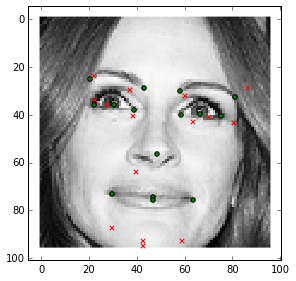

In [91]:
show_one_example(training_data[0], training_labels[0], training_labels[1])

## Establishing a baseline

In order to evaluate the value of various algorithms, we need to first establish a baseline. The baseline algorithm is both simple and shockingly effective, considering absolutely no machine learning is involved.

We take all the predictions for each keypoint in the training set and compute an arithmetic mean. Then, regardless of the input, we predict the mean value for each keypoint. This approach generates and RMSE of < 4 pixels.

Here is an example of these predictions (red) against the labeled actual keypoints (green).

*** Baseline development data score: 3.76889949349
*** Reference (R implementation score, some randomness): 3.758999
*** Baseline (mean coordinate) predictions on first example


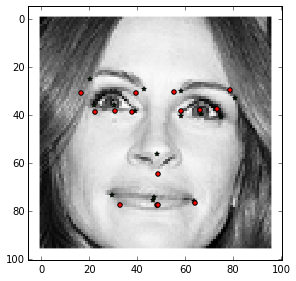

In [92]:
baseline()

To understand why this simple baseline is so effectiv, let's consider some example faces. Generally, the faces are photographed at approximately the same distance so there is little scaling error, and there is little error coming from camera rotation (in other words, up, down, left, and right are consistent for most of the data set). The most common source of error for this naive approach is the rotation of face photographed in partial profile (as well as few outliers where the faces are far off-center).

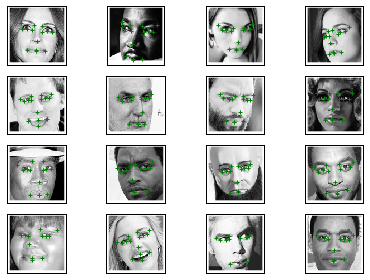

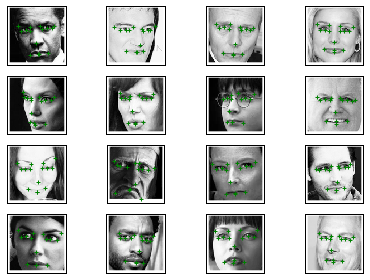

In [93]:
show_many_examples( training_data[range(16)], training_labels[range(16)] )
show_many_examples( training_data[range(16, 32)], training_labels[range(16, 32)] )

## Standard Machine Learning fails

Facial recognition is a known hard problem in Machine Learning. Again as a baseline, we can evaluate several classic algorithms. K Nearest Neighbors comes the closest but still falls short of the mean baseline (even a classic single-hidden layer neural network).

*** Score using a naive knn approach: 5.05803040541


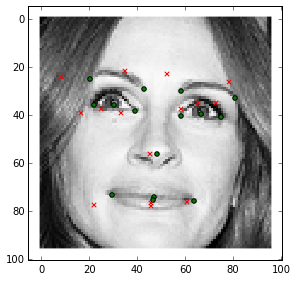

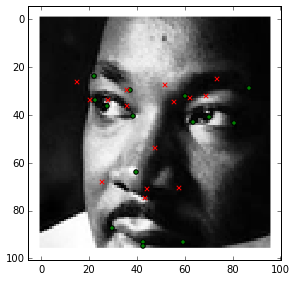

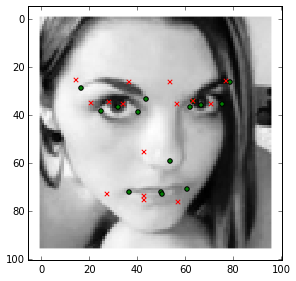

In [99]:
print('*** Score using a naive knn approach: ' + str(development_score(dev_knn_predictions_no_nan)))
show_one_example(no_nan_training_data[0], no_nan_training_labels[0], dev_knn_predictions_no_nan[0])
show_one_example(no_nan_training_data[1], no_nan_training_labels[1], dev_knn_predictions_no_nan[1])
show_one_example(no_nan_training_data[2], no_nan_training_labels[2], dev_knn_predictions_no_nan[2])

## Low Point and a Way Out

Once confirming that the simple answers made no progress, there were a few possible approaches that I considered but rejected, largely to focus on getting the maximum learning value from the project.

1) _One Net to Rule Them All_ - This approach has been extensively written about, even for this exact problem by the author of a Python Neural Networks package: [Using Convolutional Neural Nets to Detect Facial Keypoints Tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/). While undoubtedly effective, it does not offer much opportunity for breaking down the problem into a manageable model pipeline. From my previous experience building production Recommender Systems, I had come to greatly value many the traceability and maintainability of the "pipeline of simpler models" approach.

2) _Image Processing Deep-Dive_ - This is a known deep and specialized field - and if would be easy to spend months researching image processing strategies. I avoided this approach because it was not the focus of the course, but also because I wanted to apply general methods, as many previous high-performing Kaggle entrants had done.

### An insight that worked

The approach that did yield progress is to break down the problem, analogous to taking a high-speed jet flight to a distant city before finding the right house in a car. However, I again wanted to avoid a long digression on modeling the geometry of faces, but a conceptual model was necessary to transform the micro-structure (specific keypoints) into macro-structure of faces.

The insight came from an emoji - which we daily recognize as a proxy for a human face.

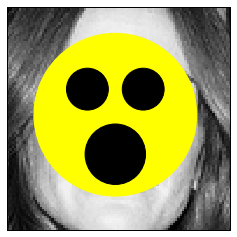

In [106]:
figure = plt.figure()
show_one_example_circles(training_data[0], None, None, figure, 1, 1, 1)
emoji = [
    [ [ 46, 46], 35, 'yellow' ],
    [ [ 34, 35], 9, 'black' ],
    [ [ 58, 35], 9, 'black' ],
    [ [ 46, 63], 13, 'black' ]
]
for circle in emoji:    
    plt.gca().add_artist(plt.Circle(circle[0], circle[1], color=circle[2], fill=True))
  
plt.show()

To take advantage of this insight, I modeled the geometry of the face as three circles:
 - left eye
 - right eye
 - nose and mouth

To determine whether to place the circle given a labeled training example, I simply grouped the keypoints into these regions, and took the centroid of the keypoints as the center of each circle, and the largest distance from the centroid to a keypoint as the radius.

Now, it was time to validate the idea on some real data by visualizing this conceptual model, and verifying that the structure was descriptive enough to train a model.

Here is an example face with the 3-circle geogmetry, and for comparison the same face with "bad predictions" (again, the labels taken from a different training example for illustration).

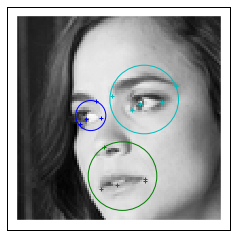

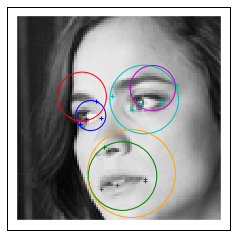

In [107]:
circle_labels_3 = labels_to_circles(training_labels[3])
show_one_example_circles(training_data[3], circle_labels_3)
fake_bad_predictions = labels_to_circles(training_labels[4])
show_one_example_circles(training_data[3], circle_labels_3, fake_bad_predictions)

This was a promising first attempt. By visualizing the approach over a bigger sample, it became clear that it has several very desirable properties:
 - effectively encodes the human intuition about the structure of the face
 - shows good variation across the sample set
 - indirectly (especially in the radii especially of the eyes) captures the 3D geometric variation of the photographs
 
Additionally, to enable further refinement of the algorithms, this 9-feature set provides a good basis for clustering kinds of faces or photographs if needed.

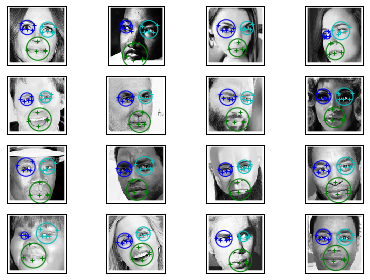

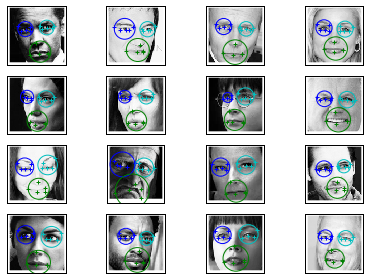

In [108]:
show_many_examples_circles( training_data[range(16)], training_circle_labels[range(16)] )
show_many_examples_circles( training_data[range(16, 32)], training_circle_labels[range(16, 32)] )

## The Path Forward

After validating the insight, this led to a general model pipeline:
  1. Detect the Left Eye
  2. Detect the Right Eye
  3. Detect the Nose and Mouth
  4. Rationalize the 3 macro-structure predictions
  5. Predict the detailed keypoints
  
The goal with (4) is, as before, not to try to encode geometric rules, but to train a model that generates refined predictions from raw predictions. Due to time constraints, 2-5 remain as Future Work.

## Left Eye Detector

Building the left eye detector again required a bit of insight. While for this test set, it would likely be solveable but training a giant complex neural network, I decided to stay with the theme of building smaller, composable models that could be used to solve related problems.

A quick reminder on what we're trying to detect:

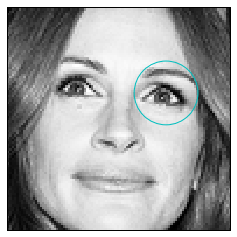

In [109]:
training_0_left_eye_only_circle = np.array([ training_circle_labels[0][0], None, None ])
show_one_example_circles(training_data[0], training_0_left_eye_only_circle)

Now to build a model, we sample a variety of left eyes. Fortunately, it looks like there's of generality to detect.

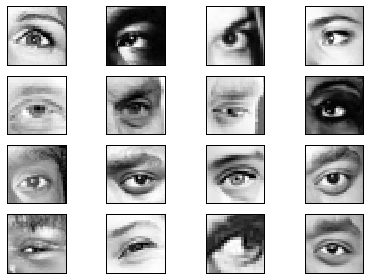

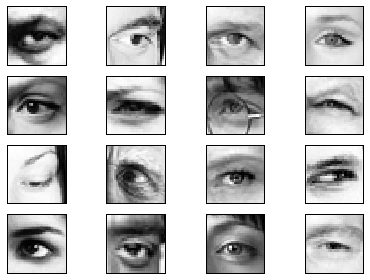

In [110]:
show_many_examples_circles( sample_left_eyes(training_data, 0, 16) )
show_many_examples_circles( sample_left_eyes(training_data, 16, 32) )

Cropping the left eyes so precisely is possible if we already know where they are. The challenge, of course to find the eyes without knowing where to look in advance. To accomplish this, I did borrow one technique from image processing called image patches.

The idea is to take common croppings (or patches) for the object we're trying to detect, and then do a systematic search through subsets of the target image, looking for a match.

In order to generate the patches, we first need to determine what size they need to be.

### 1) Setup and loading data
The first few cells are concerned with loading libraries, data sets, and setting up train/dev/test sets

##### TODO: reference Kaggle competition ###

In [32]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import linear_model, datasets, metrics
from scipy.spatial import distance

import csv



In [3]:
data_directory = '../data/'
training_csv = 'training.csv'
test_csv = 'test.csv'

def space_separated_string_to_numpy_array(string):
    return np.fromstring(string, dtype=int, sep=" ")

def read_data_as_data_frame_with_image_array(data_directory, csv):
    return pd.read_csv(data_directory + csv, converters = { 
        'Image' : space_separated_string_to_numpy_array
    })

training_and_development_df = read_data_as_data_frame_with_image_array(data_directory, training_csv)
test_df = read_data_as_data_frame_with_image_array(data_directory, test_csv)
test_data = np.array([np.array(image) for image in test_df['Image'] ])
test_image_ids = np.array(test_df['ImageId'])

# The training_shuffle is used to randomly (but the same way every time) to split the data into
# training data and development data
# Set the randomizer seed so results are the same each time.
np.random.seed(0)
training_shuffle = np.random.permutation(len(training_and_development_df.index))

In [4]:
training_df = training_and_development_df[len(test_df.index):]
development_df = training_and_development_df[:len(test_df.index)]

training_df_columns = training_df.columns.values
training_df_training_columns = np.asarray([ 'Image' ])
training_df_label_columns = training_df_columns[np.where(training_df_columns != 'Image')]
def training_label_to_index(label):
    return np.where(training_df_label_columns == label)[0]
    
def index_to_training_label(index):
    return training_df_label_columns[index]

training_data = np.array([np.array(image) for image in training_df['Image'] ])
training_labels = np.array(training_df[training_df_label_columns])
development_data = np.array([np.array(image) for image in development_df['Image'] ])
development_labels = np.array(development_df[training_df_label_columns])
label_names = training_df_label_columns
x_label_indices = [ index for index, name in enumerate(label_names) if '_x' in name ]
y_label_indices = [ index for index, name in enumerate(label_names) if '_y' in name ]

In [88]:
def describe_data():
    print(str(len(test_data)) + ' test examples and ' + 
      str(len(training_data) + len(development_data)) + ' training examples')
    print('I partitioned the original training data into ' + str(len(training_data)) + ' examples for training and '
          + str(len(development_data)) + ' holdout examples for development ')
    print('Each example contains ' + str(len(training_data[0])) + ' pixels, ' 
          + str(int(np.sqrt(len(training_data[0])))) + ' in each dimension with 255 possible greyscale values')





## 2) A way to look at the data 

Showing an example, plotting but the labels/correct answers and predictions

In [5]:
def show_one_example(example, 
                     labels = None, predictions = None,
                     label_color = 'g', label_marker = 'o',
                     prediction_color = 'r', prediction_marker = 'x'
                    ):
    
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    if labels is not None:
        x_labels = labels[x_label_indices]
        y_labels = labels[y_label_indices]
        plt.scatter(x_labels, y_labels, c = label_color, marker = label_marker)
    if predictions is not None:
        x_predictions = predictions[x_label_indices]
        y_predictions = predictions[y_label_indices]
        plt.scatter(x_predictions, y_predictions, c = prediction_color, marker = prediction_marker)
    plt.tight_layout()
    plt.show()

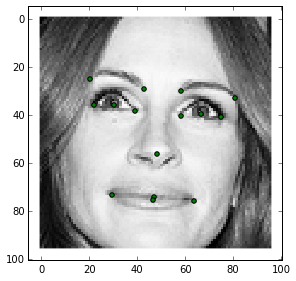

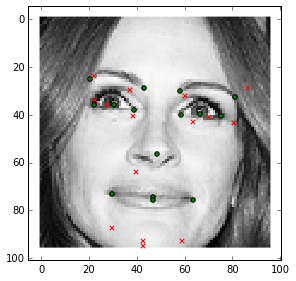

In [6]:
# intentially using the wrong predictions to show labels (green +) vs predictions (red x)
show_one_example(training_data[0], training_labels[0])
show_one_example(training_data[0], training_labels[0], training_labels[1])

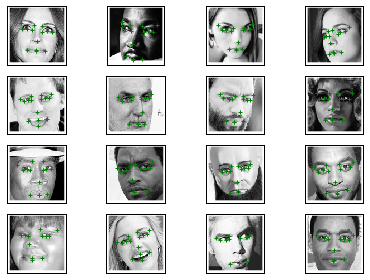

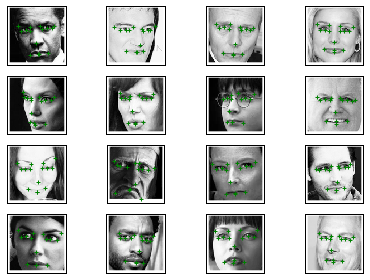

In [7]:
def show_one_example_composable(example,
                                labels = None, 
                                predictions = None,
                                existing_figure = None,
                                subplot_rows = 1,
                                subplot_columns = 1,
                                subplot_number = 1
                            ):
    pixels = len(example)
    side = int(np.sqrt(pixels))
    matrix = np.reshape(255 - example, (side, side))
    
    figure = plt.figure() if (existing_figure is None) else existing_figure
    subplot = figure.add_subplot(subplot_rows, subplot_columns, subplot_number)
        
    subplot.imshow(matrix, cmap='Greys', interpolation='Nearest')
    subplot.set_xticks(np.array([]))
    subplot.set_yticks(np.array([]))

    if labels is not None:
        x_labels = labels[x_label_indices]
        y_labels = labels[y_label_indices]
        subplot.scatter(x_labels, y_labels, c='g', marker = '+')
    if predictions is not None:
        x_predictions = predictions[x_label_indices]
        y_predictions = predictions[y_label_indices]
        subplot.scatter(x_predictions, y_predictions, c='r', marker='x')

    if existing_figure is None:
        plt.show()

def show_many_examples(examples, 
                       labels_array = None, 
                       predictions_array = None,
                       columns = 4
                      ):
    count = len(examples)
    
    rows = int(np.ceil( (1.0 * count) / (1.0 * columns) ))
    
    figure = plt.figure()
    for index, example in enumerate(examples):
        labels = labels_array[index] if (labels_array is not None) else None
        predictions = predictions_array[index] if (predictions_array is not None) else None

        
        show_one_example_composable(example, 
                                 labels, predictions, 
                                 figure, rows, columns, index + 1)
        
    figure.tight_layout()
    plt.show()
    
show_many_examples( training_data[range(16)], training_labels[range(16)] )
show_many_examples( training_data[range(16, 32)], training_labels[range(16, 32)] )

## 3) Computing of the error (we use pixel RMSE)

Some functions for overall fitness scoring (`development_score`) as well as for looking for errors

In [8]:
def compute_example_squared_errors(example_predicted, example_labels):
    return [ 
        (example_predicted[index] - label) ** 2
        for index, label 
        in enumerate(example_labels) 
    ]

def compute_error_squared_matrix(all_examples_predicted, all_examples_labels):
    return [
        compute_example_squared_errors(example_predicted, all_examples_labels[index])
        for index, example_predicted
        in enumerate(all_examples_predicted)
    ]

def rmse(error_matrix):
    return np.sqrt(np.nanmean(error_matrix))

def development_score(development_predictions):
    error_matrix = np.matrix(
        compute_error_squared_matrix(development_predictions, development_labels)
    )
    
    return rmse(error_matrix)

## 4) Establishing a baseline (simple mean of training algorithm)

*** Baseline development data score: 3.76889949349
*** Reference (R implementation score, some randomness): 3.758999
*** Baseline (mean coordinate) predictions on first example


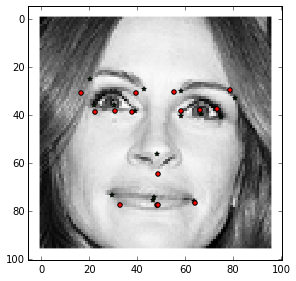

In [9]:

# Baseline - predict the mean keypoints for the training set
baseline_mean_predictions = {
        name: np.mean(
            [ 
                training_label[index] 
                for training_label 
                in training_labels 
                if training_label[index] >= 0.0
            ]
        )
        for index, name

        in enumerate(label_names)
    }

baseline_mean_predictions_array = np.array([ baseline_mean_predictions[name] for name in label_names ])

def baseline_mean_predict(example):
    return baseline_mean_predictions_array   

def baseline():
    baseline_development_predictions = [ 
        baseline_mean_predict(example) 
        for example 
        in development_data 
    ]
    
    baseline_development_score = development_score(baseline_development_predictions)
    print('*** Baseline development data score: ' + str(baseline_development_score))
    
    print('*** Reference (R implementation score, some randomness): 3.758999') 
    print('*** Baseline (mean coordinate) predictions on first example')
    
    show_one_example(training_data[0], training_labels[0], baseline_mean_predict(training_data[0]),
                    label_color = 'g', label_marker = '*', prediction_color = 'r', prediction_marker = 'o')
                     
baseline()

## 5) A very naive ML baseline - using KNearestNeighbors

We will use K nearest neighbors to predict each keypoint

In [95]:
no_nan_training_labels = [
    label
    for index, label
    in enumerate(training_labels)
    if not np.isnan(label).any()
]

no_nan_training_data = [
    training_data[index]
    for index, label
    in enumerate(training_labels)
    if not np.isnan(label).any()
]

knn = KNeighborsClassifier(neighbors)
knn.fit(no_nan_training_data, no_nan_training_labels)

dev_knn_predictions_no_nan = knn.predict(development_data)

In [96]:
development_score(dev_knn_predictions_no_nan)

5.0580304054096752

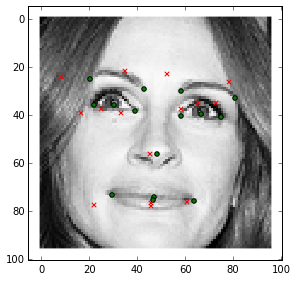

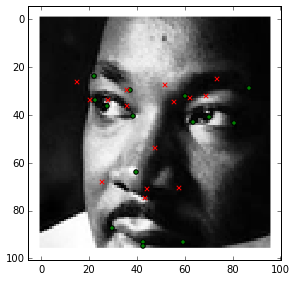

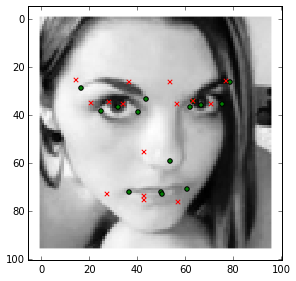

*** Score using a naive knn approach: 5.05803040541


In [98]:
show_one_example(no_nan_training_data[0], no_nan_training_labels[0], dev_knn_predictions_no_nan[0])
show_one_example(no_nan_training_data[1], no_nan_training_labels[1], dev_knn_predictions_no_nan[1])
show_one_example(no_nan_training_data[2], no_nan_training_labels[2], dev_knn_predictions_no_nan[2])
print('*** Score using a naive knn approach: ' + str(development_score(dev_knn_predictions_no_nan)))

###### 




























## 6) Turning point

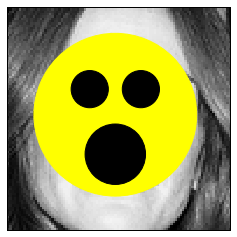

In [68]:
example = training_data[0]
figure = plt.figure()
show_one_example_circles(example, None, None, figure, 1, 1, 1)
circle_plt = plt.Circle([ 46, 46], 35, color='yellow', fill=True)
plt.gca().add_artist(circle_plt)
circle_plt = plt.Circle([ 35, 35], 8, color='black', fill=True)
plt.gca().add_artist(circle_plt)
circle_plt = plt.Circle([ 57, 35], 8, color='black', fill=True)
plt.gca().add_artist(circle_plt)
circle_plt = plt.Circle([ 46, 63], 13, color='black', fill=True)
plt.gca().add_artist(circle_plt);


## 6) Finding 3 key regions (left eye, right eye, mouth and nose)

We will model the regions with 3 circles and transform the label set into the centers and radii of each circle
(left eye, right eye, mouth and nose)

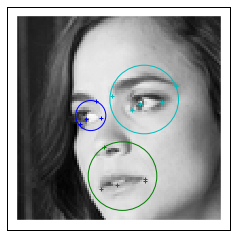

In [13]:
label_name_index = {
    name: index
    for index, name
    in enumerate(label_names)
}

def get_named_label(labels, name):
    return labels[label_name_index[name]]

def get_x(point):
    return point[0]

def get_y(point):
    return point[1]

def get_r(circle):
    return circle[2]

def points_to_circles(points):
    non_nan_points = [
        point
        for point 
        in points
        if (not np.isnan(get_x(point)) ) and (not np.isnan(get_y(point)))
    ]
    
    if len(non_nan_points) > 0:
    
        X = [ get_x(point) for point in non_nan_points ]
        Y = [ get_y(point) for point in non_nan_points ]

        centroid = [ np.mean(X), np.mean(Y) ]
        radius = np.max([ distance.euclidean(point, centroid) for point in non_nan_points  ])
        return [ get_x(centroid), get_y(centroid), radius ]
    else: 
        return None
    
def labels_to_circles(labels):
    def value(name):
        return get_named_label(labels, name)
    
    left_eye_points = [
        [ value('left_eye_center_x'), value('left_eye_center_y') ],
        [ value('left_eye_inner_corner_x'), value('left_eye_inner_corner_y') ],
        [ value('left_eye_outer_corner_x'), value('left_eye_outer_corner_y') ],
        [ value('left_eyebrow_inner_end_x'), value('left_eyebrow_inner_end_y') ],
        [ value('left_eyebrow_outer_end_x'), value('left_eyebrow_outer_end_y') ]
    ]
    
    right_eye_points = [
        [ value('right_eye_center_x'), value('right_eye_center_y') ],
        [ value('right_eye_inner_corner_x'), value('right_eye_inner_corner_y') ],
        [ value('right_eye_outer_corner_x'), value('right_eye_outer_corner_y') ],
        [ value('right_eyebrow_inner_end_x'), value('right_eyebrow_inner_end_y') ],
        [ value('right_eyebrow_outer_end_x'), value('right_eyebrow_outer_end_y') ]
    ]
    
    mouth_and_nose_points = [
        [ value('mouth_center_bottom_lip_x'), value('mouth_center_bottom_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_center_top_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_left_corner_y') ],
        [ value('mouth_right_corner_x'), value('mouth_right_corner_y') ],
        [ value('nose_tip_x'), value('nose_tip_y') ]
    ]
    
    return [
        points_to_circles(left_eye_points), 
        points_to_circles(right_eye_points),
        points_to_circles(mouth_and_nose_points),
        left_eye_points,
        right_eye_points,
        mouth_and_nose_points
    ]

def get_left_eye_circle(circle_labels):
    return circle_labels[0] if len(circle_labels) > 0 else None

def get_right_eye_circle(circle_labels):
    return circle_labels[1] if len(circle_labels) > 1 else None

def get_mouth_and_nose_circle(circle_labels):
    return circle_labels[2] if len(circle_labels) > 2 else None


def show_one_example_circles(example, 
                             circle_labels = None, 
                             circle_predictions = None, 
                             existing_figure = None,
                             subplot_rows = 1,
                             subplot_columns = 1,
                             subplot_number = 1,
                             score = None
                            ):
    pixels = len(example)
    side = int(np.sqrt(pixels))
    matrix = np.reshape(255 - example, (side, side))
    
    figure = plt.figure() if (existing_figure is None) else existing_figure
    subplot = figure.add_subplot(subplot_rows, subplot_columns, subplot_number)
        
    subplot.imshow(matrix, cmap='Greys', interpolation='Nearest')
    subplot.set_xticks(np.array([]))
    subplot.set_yticks(np.array([]))
    
    def show_circle(circle, color, points = None, marker = None):
        if circle is not None:
            circle_plt = plt.Circle(
                [ get_x(circle), get_y(circle)], 
                get_r(circle), 
                color=color, 
                fill=False
            )
            plt.gca().add_artist(circle_plt)
        
        if points is not None:
            X = [ get_x(point) for point in points ]
            Y = [ get_y(point) for point in points ]
            subplot.scatter(X, Y, c = color, marker = marker)
        
    if circle_labels is not None:
        
        left_eye_circle = get_left_eye_circle(circle_labels)
        right_eye_circle = get_right_eye_circle(circle_labels)
        mouth_and_nose_circle = get_mouth_and_nose_circle(circle_labels)
        
        left_eye_points = None
        right_eye_points = None
        mouth_and_nose_points = None

        left_eye_points = circle_labels[3] if (len(circle_labels) > 3) else None
        right_eye_points = circle_labels[4] if (len(circle_labels) > 3) else None
        mouth_and_nose_points = circle_labels[5] if (len(circle_labels) > 3) else None
        
        show_circle(left_eye_circle, 'c', left_eye_points, '+')
        show_circle(right_eye_circle, 'b', right_eye_points, '+')
        show_circle(mouth_and_nose_circle, 'g', mouth_and_nose_points, '+')

    if circle_predictions is not None:
        pred_left_eye_circle = get_left_eye_circle(circle_predictions)
        pred_right_eye_circle = get_right_eye_circle(circle_predictions)
        pred_mouth_and_nose_circle = get_mouth_and_nose_circle(circle_predictions)
        
        show_circle(pred_left_eye_circle, 'm')
        show_circle(pred_right_eye_circle, 'r')
        show_circle(pred_mouth_and_nose_circle, 'orange')
        
    if score is not None:
        score_text = "{:4.3f}".format(score)
        subplot.text(side / 2, side / 2, score_text, 
                     color = 'orange', size = 'xx-large', weight = 'extra bold',
                     horizontalalignment = 'center', verticalalignment = 'center')
    
    if existing_figure is None:
        plt.show()
        
circle_labels_3 = labels_to_circles(training_labels[3])
show_one_example_circles(training_data[3], circle_labels_3)



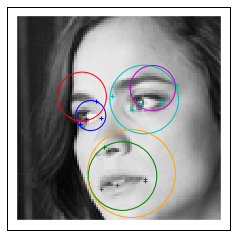

In [14]:
fake_bad_predictions = labels_to_circles(training_labels[4])
show_one_example_circles(training_data[3], circle_labels_3, fake_bad_predictions)

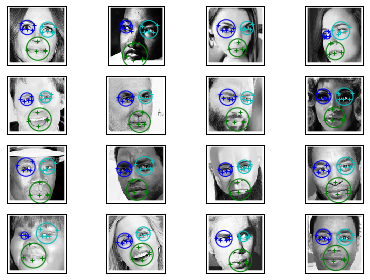

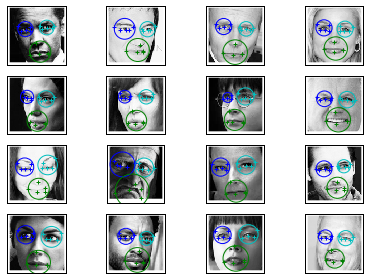

In [15]:
def show_many_examples_circles(examples, 
                               circle_labels_array = None, 
                               circle_predictions_array = None,
                               columns = 4,
                               scores_array = None
                              ):
    
    count = len(examples)
    
    rows = int(np.ceil( (1.0 * count) / (1.0 * columns) ))
    
    figure = plt.figure()
    for index, example in enumerate(examples):
        circle_labels = circle_labels_array[index] if (not (circle_labels_array is None)) else None
        circle_predictions = circle_predictions_array[index] if (not (circle_predictions_array is None)) else None
        score = scores_array[index] if (scores_array is not None) else None
        
        show_one_example_circles(example, 
                             circle_labels, circle_predictions, 
                             figure, rows, columns, index + 1,
                                score)
        
    figure.tight_layout()
    plt.show()

training_circle_labels = np.array([ labels_to_circles(labels) for labels in training_labels ])

show_many_examples_circles( training_data[range(16)], training_circle_labels[range(16)] )
show_many_examples_circles( training_data[range(16, 32)], training_circle_labels[range(16, 32)] )

## 7) The eye is the window the to the soul

-- every poet ever

### let's build a left eye detector!


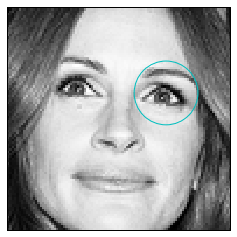

In [16]:
training_0_left_eye_only_circle = np.array([ training_circle_labels[0][0], None, None ])
show_one_example_circles(training_data[0], training_0_left_eye_only_circle)

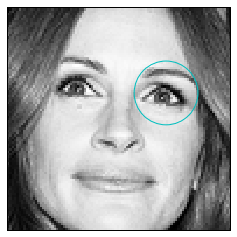

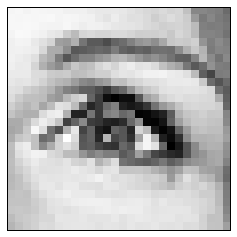

In [17]:

def excise(example, circle):
    pixels = len(example)
    side = int(np.sqrt(pixels))
    matrix = np.reshape(example, (side, side))
    
    def lookup(arg_x, arg_y):
        if (arg_x >= 0) and (arg_x < side) and (arg_y >= 0) and (arg_y < side):
            return matrix[arg_y][arg_x]
        else:
            return 0
    
    if circle is not None:
        circle_x = int(np.round(get_x(circle)))
        circle_y = int(np.round(get_y(circle)))
        circle_r = int(np.ceil(get_r(circle)))

        x_min = circle_x - circle_r
        x_max = circle_x + circle_r
        y_min = circle_y - circle_r
        y_max = circle_y + circle_r

        submatrix = np.array([
            np.array([
                lookup(iter_x, iter_y)
                for iter_y in
                range(y_min, y_max)
            ])
            for iter_x in
            range(x_min, x_max)
        ])

        return np.ravel(np.transpose(submatrix))
    else:
        return None

show_one_example_circles(training_data[0], training_0_left_eye_only_circle)
left_eye_0 = excise(training_data[0], get_left_eye_circle(training_circle_labels[0]))
show_one_example_circles(left_eye_0)

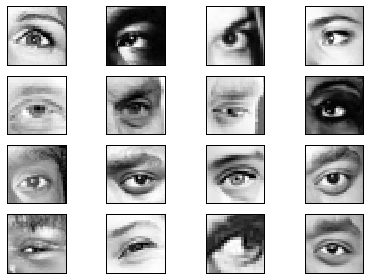

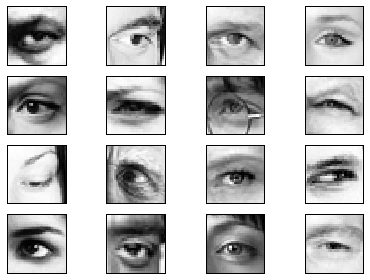

In [18]:
def sample_left_eyes(data, start, end):    
    return [
        excise(data[index], get_left_eye_circle(training_circle_labels[index]))
        for index
        in range(start, end)
    ]

show_many_examples_circles( sample_left_eyes(training_data, 0, 16) )
show_many_examples_circles( sample_left_eyes(training_data, 16, 32) )

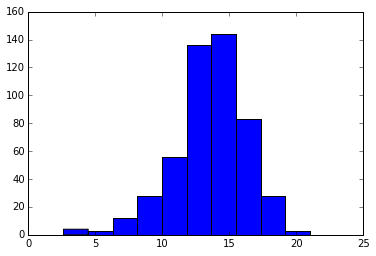

In [19]:
left_eye_circles = [ 
    get_left_eye_circle(training_circle_labels[index]) 
    for index 
    in range(len(training_circle_labels)) 
]

left_eye_circle_radii = [ 
    get_r(circle)
    for circle 
    in left_eye_circles 
    if circle is not None and len(circle) > 2 and get_r(circle) > 0.0 
]
plt.hist(left_eye_circle_radii);


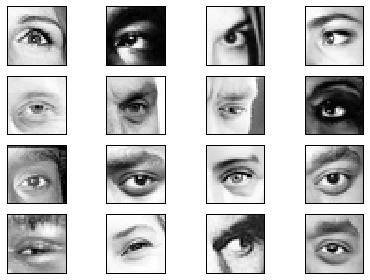

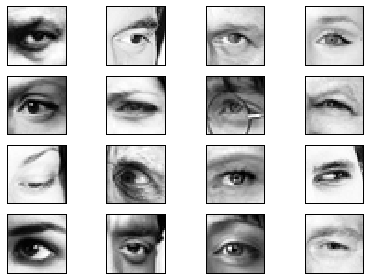

In [20]:
def circle_constrain_radius(circle, radius):
    if circle is not None:
        return [ get_x(circle), get_y(circle), radius ]
    else:
        return None
    
def sample_left_eyes_constrain_radius(data, start, end, radius):    
    return [
        excise(
            data[index], 
            circle_constrain_radius(
                get_left_eye_circle(training_circle_labels[index]),
                radius
            )
        )
        for index
        in range(start, end)
    ]

show_many_examples_circles( sample_left_eyes_constrain_radius(training_data, 0, 16, 16) )
show_many_examples_circles( sample_left_eyes_constrain_radius(training_data, 16, 32, 16) )

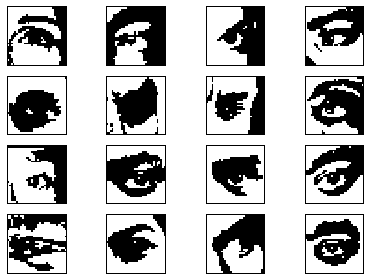

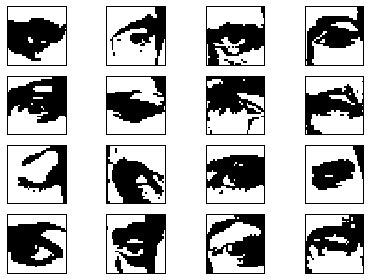

In [21]:
def binarize_at_mean(image):
    mean = np.mean(image)
    return np.array([
            255 if pixel > mean else 0
            for pixel
            in image
    ])

def binarize_all_at_mean(images):
    return np.array([
            binarize_at_mean(image)
            for image
            in images
            if image is not None
            ]);
show_many_examples_circles( binarize_all_at_mean(sample_left_eyes_constrain_radius(training_data, 0, 16, 16)) )
show_many_examples_circles( binarize_all_at_mean(sample_left_eyes_constrain_radius(training_data, 16, 32, 16)) )

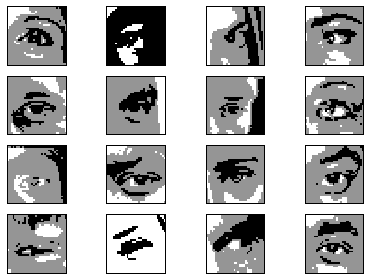

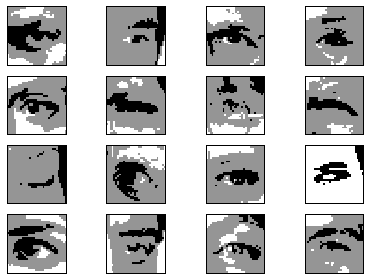

In [22]:
def ternarize_map_pixel(pixel, mean, sd, display = False):
    if pixel < mean - sd:
        return 0 if display == True else -1
    elif pixel < mean + sd:
        return 127 if display == True else 0
    else:
        return 255 if display == True else 1

def ternarize_around_mean(image, display = False):
    mean = np.mean(image)
    sd = np.std(image)
    return np.array([
            ternarize_map_pixel(pixel, mean, sd, display)
            for pixel
            in image
    ])

def ternarize_all_around_mean(images, display = False):
    return np.array([
            ternarize_around_mean(image, display)
            for image
            in images
            if image is not None
            ]);
show_many_examples_circles( ternarize_all_around_mean(sample_left_eyes_constrain_radius(training_data, 0, 16, 16), True) )
show_many_examples_circles( ternarize_all_around_mean(sample_left_eyes_constrain_radius(training_data, 16, 32, 16), True) )

In [23]:
mini_train_data = training_data[range(100)]
mini_train_labels = training_labels[range(100)]
mini_train_circle_labels = training_circle_labels[range(100)]

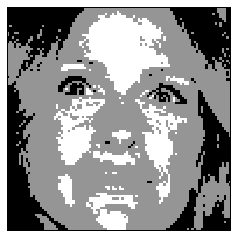

In [24]:
show_one_example_circles(ternarize_around_mean(training_data[0], True))

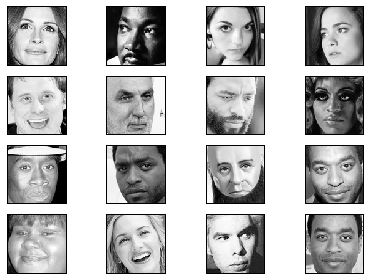

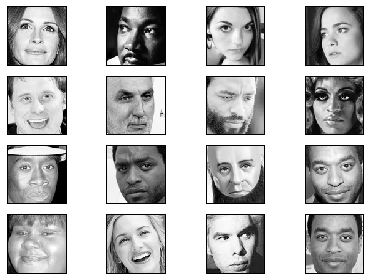

*** un-normalized mean: 138.544053819
*** un-normalized stddev: 67.6340218121
*** normalized mean: 127.500976562
*** normalized stddev: 42.5046744662


In [25]:
def normalize_map_pixel(pixel, mean, sd, display = False):
    if sd >= 1.0:
        z_score = (1.0 * pixel - 1.0 * mean) / (1.0 * sd)
    else:
        z_score = 0.0
    
    if display:
        # map z-score = [-3, 3] to [0, 255]
        value = 127.5 + (127.5 * z_score / 3.0)
        if value < 0.0:
            return 0
        elif value > 255.0:
            return 255
        else:
            return int(np.round(value))
    else:
        return z_score
    

def normalize_around_mean(image, display = False):
    mean = np.mean(image)
    sd = np.std(image)
    return np.array([
            normalize_map_pixel(pixel, mean, sd, display)
            for pixel
            in image
    ])

def normalize_all_around_mean(images, display = False):
    return np.array([
            normalize_around_mean(image, display)
            for image
            in images
            if image is not None
            ]);

show_many_examples_circles( training_data[range(16)] )
show_many_examples_circles( normalize_all_around_mean( training_data[range(16)], True ) )
print('*** un-normalized mean: ' + str(np.mean(training_data[0])))
print('*** un-normalized stddev: ' + str(np.std(training_data[0])))
print('*** normalized mean: ' + str(np.mean(normalize_around_mean(training_data[0], True))))
print('*** normalized stddev: ' + str(np.std(normalize_around_mean(training_data[0], True))))

## 8) Show me your eye patch



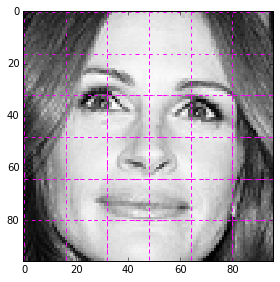

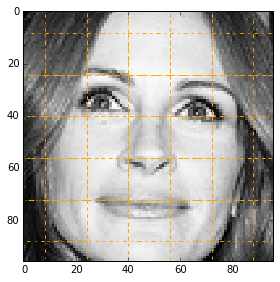

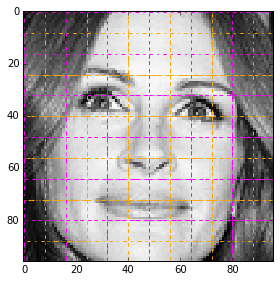

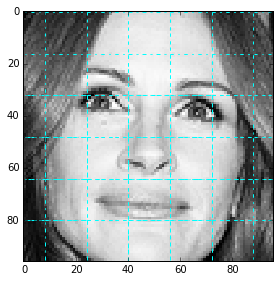

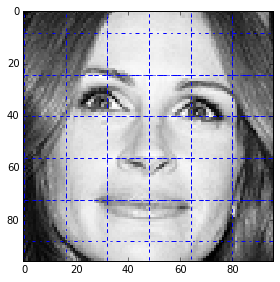

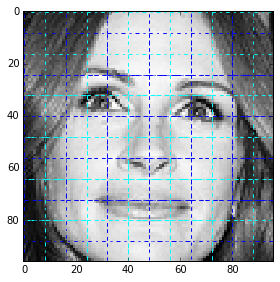

In [26]:
def generate_eye_patches(radius = 16, side = 92):
    increment = radius / 2
    eye_patches = np.array([
        [ x, y, radius ]
        for y in range(increment, side + increment, increment)
        for x in range(increment, side + increment, increment)
    ])
    
    return eye_patches

eye_patches_radius_16 = generate_eye_patches(16, 92)

def show_eye_patching(example, eye_patches, radius = 16, 
                      show_grid = True, show_syncopation = False,
                      show_syncopation_x = False, show_syncopation_y = False
                     ):
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    
    for eye_patch in eye_patches:
        corner_x = get_x(eye_patch) - radius
        corner_y = get_y(eye_patch) - radius
        
        if (corner_x % radius == 0) and (corner_y % radius == 0):
            if show_grid:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='magenta', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        elif not (corner_x % radius == 0) and not (corner_y % radius == 0):
            if show_syncopation:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='orange', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        elif not (corner_x % radius == 0) and (corner_y % radius == 0):
            if show_syncopation_x:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='cyan', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)
        else:
            if show_syncopation_y:
                square = plt.Rectangle(
                       (corner_x, corner_y), radius * 2, radius * 2, 
                        color='blue', fill = False, linestyle = 'dashdot', linewidth = 1
                    )
                plt.gca().add_artist(square)

    plt.tight_layout()
    plt.show()
    
show_eye_patching(training_data[0], eye_patches_radius_16, 16, True, False, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, True, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, True, True, False, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, True, False)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, False, True)
show_eye_patching(training_data[0], eye_patches_radius_16, 16, False, False, True, True)


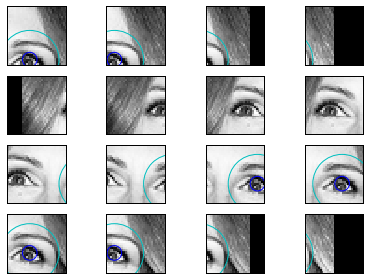

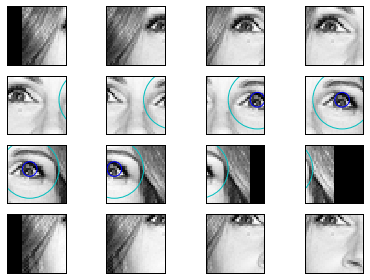

In [27]:
def generate_indicators(eye_patch, example_circle_labels, radius = 16):
    eye_patch_x_offset = get_x(eye_patch) - get_r(eye_patch)
    eye_patch_y_offset = get_y(eye_patch) - get_r(eye_patch)
    left_eye_circle = get_left_eye_circle(example_circle_labels)
    left_eye_circle_adjusted = [
        get_x(left_eye_circle) - eye_patch_x_offset,
        get_y(left_eye_circle) - eye_patch_y_offset,
        get_r(left_eye_circle)
    ]
    return [ 
                [ get_x(left_eye_circle_adjusted), get_y(left_eye_circle_adjusted), radius ], 
                [ get_x(left_eye_circle_adjusted), get_y(left_eye_circle_adjusted), radius / 4 ] 
    ]

def show_eye_patch_samples(example, eye_patches, subset, example_circle_labels = None, radius = 16, scores = None):
    images = [
        excise(example, eye_patch) 
        for eye_patch 
        in eye_patches[subset]
    ]
    indicators = [
        generate_indicators(eye_patch, example_circle_labels, radius)
        for eye_patch
        in eye_patches[subset]
    ]

    show_many_examples_circles(images, indicators, None, 4, scores)

show_eye_patch_samples(training_data[0], eye_patches_radius_16, range(32, 48), training_circle_labels[0])
show_eye_patch_samples(training_data[0], eye_patches_radius_16, range(48, 64), training_circle_labels[0])


In [28]:
def get_circle_center(circle):
    if circle is not None:
        return [ get_x(circle), get_y(circle) ]
    else:
        return None

def map_distance(distance, radius = 16):
    zero_value_distance = 1.0 * radius * np.sqrt(2.0)
    fitness = (zero_value_distance - distance) / zero_value_distance
    return fitness if fitness > 0.0 else 0.0

def excise_for_neural_net(example, eye_patch):
    return excise(example, eye_patch) / 255.0

left_eye_detector_mini_training_data = np.array([
    excise_for_neural_net(example, eye_patch)
    for example in mini_train_data
    for eye_patch in eye_patches_radius_16
])

radius = 16
left_eye_detector_mini_training_indicators = np.array([ 
    generate_indicators(eye_patch, circle_label, radius)
    for circle_label in mini_train_circle_labels
    for eye_patch in eye_patches_radius_16
])

left_eye_detector_mini_training_scores = np.array([ 
    map_distance(
        distance.euclidean(
            get_circle_center(eye_patch), 
            get_circle_center(get_left_eye_circle(circle_label))
        )
    )
    for circle_label in mini_train_circle_labels
    for eye_patch in eye_patches_radius_16
])

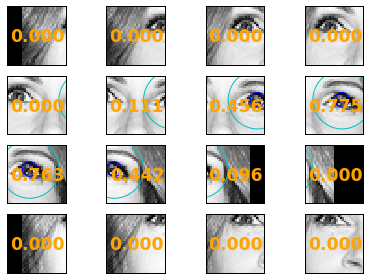

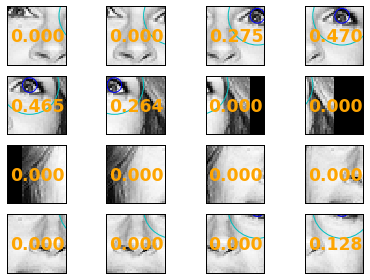

In [29]:
def show_eye_patch_subset(subset, all_eye_patches, all_indicators = None, all_scores = None, radius = 16):
    eye_patches = all_eye_patches[subset]
    
    indicators = all_indicators[subset] if all_indicators is not None else None
    
    scores = all_scores[subset] if all_scores is not None else None

    show_many_examples_circles(eye_patches, indicators, None, 4, scores)
    
n = 48
show_eye_patch_subset(
    np.array( range(n, n + 16) ), 
    left_eye_detector_mini_training_data,
    left_eye_detector_mini_training_indicators,
    left_eye_detector_mini_training_scores
)
n = 48
show_eye_patch_subset(
    np.array( range(n + 16, n + 32) ), 
    left_eye_detector_mini_training_data,
    left_eye_detector_mini_training_indicators,
    left_eye_detector_mini_training_scores
)

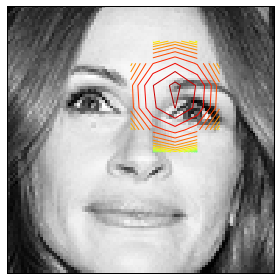

In [40]:
def contour_plot_example_with_labels(example, circle_labels, eye_patches = eye_patches_radius_16):
    example_scores = np.array([ 
        map_distance(
            distance.euclidean(
                get_circle_center(eye_patch), 
                get_circle_center(get_left_eye_circle(circle_label))
            )
        )
        for eye_patch in eye_patches
    ])
    
    contour_plot_example_with_scores(example, example_scores, eye_patches)
    
def contour_plot_example_with_scores(example, example_scores, eye_patches = eye_patches_radius_16, prediction = None):
    x = np.array([ get_x(eye_patch) for eye_patch in eye_patches ]) - (radius/4)
    y = np.array([ get_y(eye_patch) for eye_patch in eye_patches ]) - (radius/4)
    z = example_scores
    
    side = int(np.sqrt(len(x)))
    X = np.reshape(x, (side, side))
    Y = np.reshape(y, (side, side))
    Z = np.reshape(z, (side, side))

    figure = plt.figure()
    show_one_example_circles(example, 
                             None, None, 
                             figure, 1, 1, 1)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=0.001, vmax=1.0)
                     ,levels=np.logspace(-10, 0, 100)
                    )
    
    if prediction is not None:
        plt.scatter([ get_x(prediction) ], [ get_y(prediction) ], c = 'magenta', marker = 'o')
    
    figure.tight_layout()
    plt.show()

contour_plot_example_with_labels(training_data[0], training_circle_labels[0])

## 8) Ready for some Machine Learning

In [30]:
left_eye_neural_net = BernoulliRBM(random_state=0, verbose=True)
left_eye_neural_net.learning_rate = 0.06
left_eye_neural_net.n_iter = 100
left_eye_neural_net.n_components = 144

left_eye_neural_net.fit(left_eye_detector_mini_training_data, left_eye_detector_mini_training_scores)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -565.41, time = 4.32s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -566.30, time = 4.80s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -555.64, time = 4.74s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -553.00, time = 4.75s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -540.55, time = 4.89s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -542.96, time = 4.98s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -543.31, time = 4.76s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -533.32, time = 4.84s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -531.64, time = 4.83s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -530.72, time = 4.72s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -529.02, time = 4.73s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -532.24, time = 4.87s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -521.37, time = 4.75s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -518.63, time = 4.69s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=144, n_iter=100,
       random_state=0, verbose=True)

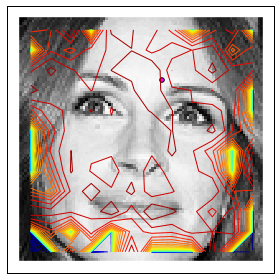

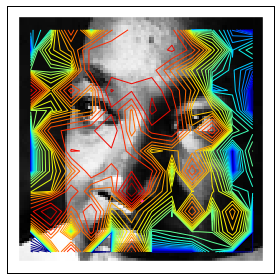

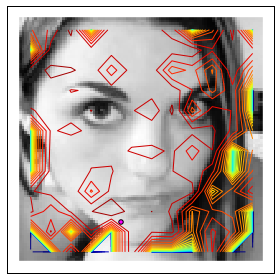

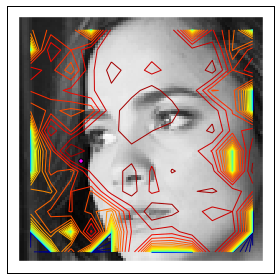

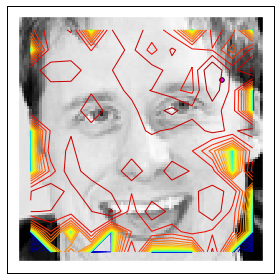

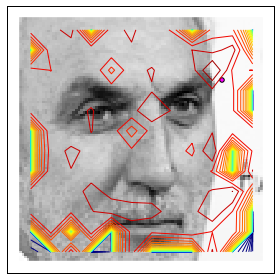

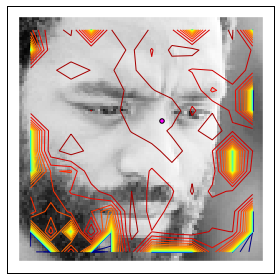

In [60]:
def generate_example_eye_patches(example, eye_patches = eye_patches_radius_16):  
    return np.array([
        excise_for_neural_net(example, eye_patch)
        for eye_patch in eye_patches
    ])

def generate_scaled_example_scores(
        example, classifier = left_eye_neural_net, eye_patches = eye_patches_radius_16
    ):
    example_eye_patches = generate_example_eye_patches(example, eye_patches)
    raw_scores = classifier.score_samples(example_eye_patches)
    min_score = np.min(raw_scores)
    return raw_scores / min_score

def generate_scaled_scored_contour_plot(
        example, classifier = left_eye_neural_net, eye_patches = eye_patches_radius_16,
        prediction = None  
    ):
    
    example_scores = generate_scaled_example_scores(example, classifier, eye_patches)
    
    if prediction is None:
        prediction_index = np.argmax(example_scores)
        prediction_used = eye_patches[prediction_index]
    else:
        prediction_used = prediction
    
    contour_plot_example_with_scores(example, example_scores, eye_patches, prediction_used)

generate_scaled_scored_contour_plot(training_data[0])
generate_scaled_scored_contour_plot(training_data[1])
generate_scaled_scored_contour_plot(training_data[2])
generate_scaled_scored_contour_plot(training_data[3])
generate_scaled_scored_contour_plot(training_data[4])
generate_scaled_scored_contour_plot(training_data[5])
generate_scaled_scored_contour_plot(training_data[6])

In [61]:
side = 92
first_pass_mini_scores = np.array([
            generate_scaled_example_scores(example)
            for example
            in mini_train_data
        ])

In [62]:
first_pass_mini_labels_x = [
        get_x(get_left_eye_circle(training_circle_label)) / (1.0 * side)
        for training_circle_label
        in mini_train_circle_labels
    ]
first_pass_mini_labels_y = [
        get_y(get_left_eye_circle(training_circle_label)) / (1.0 * side)
        for training_circle_label
        in mini_train_circle_labels
    ]

In [63]:
logistic_left_eye_mini_x = linear_model.LogisticRegression()
logistic_left_eye_mini_x.fit(first_pass_mini_scores, first_pass_mini_labels_x)

logistic_left_eye_mini_y = linear_model.LogisticRegression()
logistic_left_eye_mini_y.fit(first_pass_mini_scores, first_pass_mini_labels_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [64]:
mini_x_predictions = logistic_left_eye_mini_x.predict(first_pass_mini_scores)
mini_y_predictions = logistic_left_eye_mini_y.predict(first_pass_mini_scores)
def get_mini_prediction(index):
    return [ 
        int(round(mini_x_predictions[index] * side)), 
        int(round(mini_y_predictions[index] * side))
    ]

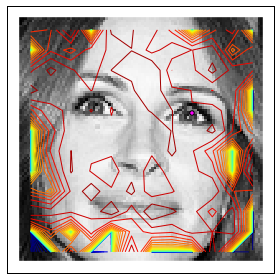

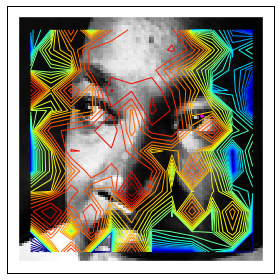

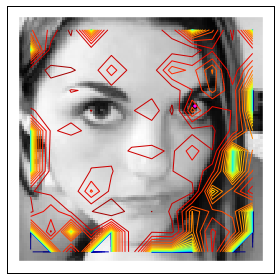

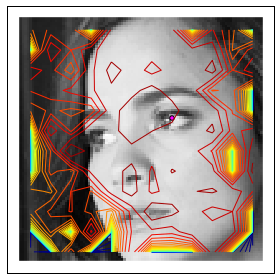

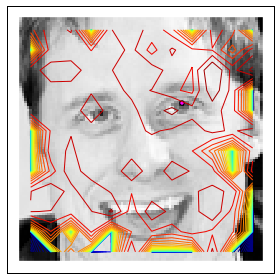

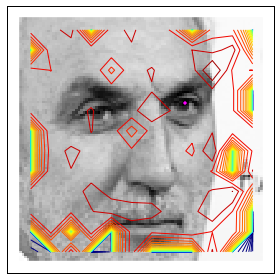

In [65]:
for n in range(6):
    generate_scaled_scored_contour_plot(
        mini_train_data[n], 
        left_eye_neural_net, 
        eye_patches_radius_16, 
        get_mini_prediction(n)
    )

In [53]:
side = 92
first_pass_scores = np.array([
            generate_scaled_example_scores(example)
            for example
            in training_data
        ])

In [55]:
first_pass_mini_labels_x = [
        get_x(get_left_eye_circle(training_circle_label)) / (1.0 * side)
        for training_circle_label
        in mini_train_circle_labels
    ]

first_pass_mini_labels_y = [
        get_y(get_left_eye_circle(training_circle_label)) / (1.0 * side)
        for training_circle_label
        in mini_train_circle_labels
    ]

left_eye_backfill = np.array([ np.mean(first_pass_mini_labels_x), np.mean(first_pass_mini_labels_y), 16.0 ])

def backfill_if_needed(left_eye):
    if left_eye is not None:
        return left_eye
    else:
        return left_eye_backfill

first_pass_labels_x = [
        get_x(backfill_if_needed(get_left_eye_circle(training_circle_label))) / (1.0 * side)
        for training_circle_label
        in training_circle_labels
    ]

first_pass_labels_y = [
        get_y(backfill_if_needed(get_left_eye_circle(training_circle_label))) / (1.0 * side)
        for training_circle_label
        in training_circle_labels
    ]

In [58]:
logistic_left_eye_x = linear_model.LogisticRegression()
logistic_left_eye_x.fit(first_pass_scores, first_pass_labels_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [69]:
logistic_left_eye_y = linear_model.LogisticRegression()
logistic_left_eye_y.fit(first_pass_scores, first_pass_labels_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [640]:
pipelined_classifier = classifier

In [631]:

def predict_left_eye(example, classifier = classifier, eye_patches = eye_patches_radius_16):
    
example_0_patches = np.array([
    excise(training_data[0], eye_patch)
    for eye_patch in eye_patches_radius_16
])
example_0_scores = classifier.predict(example_0_patches)
example_0_scores[3]


0.0

In [443]:
left_eye_detector_train_labels[range(len(eye_patches))]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
rbm.learning_rate = 0.06
rbm.n_iter = 100

rbm.n_components = 250
rbm.fit(left_eye_detector_train_data, left_eye_detector_train_labels)



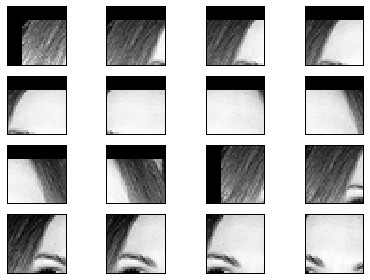

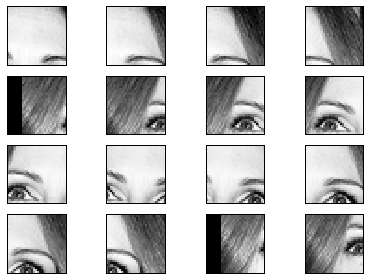

In [437]:
example_0_patches = np.array([
    excise(mini_train_data[0], eye_patch)
    for eye_patch in eye_patches
])

show_many_examples_circles(example_0_patches[range(0,16)])
show_many_examples_circles(example_0_patches[range(16,32)])



#detections = rbm.score_samples(example_0_patches)
#detections

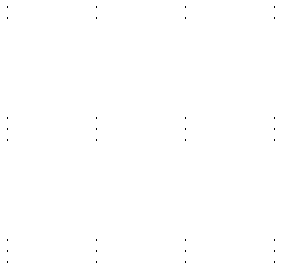

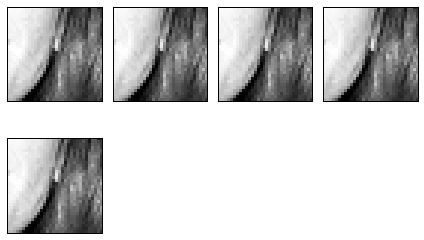

In [432]:
X = [
    get_x(eye_patches[index])
    for index, value in enumerate(detections)
    if not value == 0.0
]

Y = [
    get_y(eye_patches[index])
    for index, value in enumerate(detections)
    if not value == 0.0
]

detected = np.array([
    excise(mini_train_data[0], eye_patch)
    for index, value in enumerate(detections)
    if not value == 0.0
])

np.shape(detected)

show_many_examples_circles(example_0_patches)
show_many_examples_circles(detected)


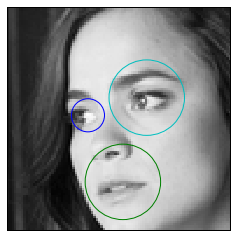

In [203]:
def circles_to_vector(circles):
    left_eye_circle = circles[0]
    right_eye_circle = circles[1]
    mouth_and_nose_circle = circles[2]
    
    return [ 
        x(left_eye_circle), y(left_eye_circle), r(left_eye_circle),
        x(right_eye_circle), y(right_eye_circle), r(right_eye_circle),
        x(mouth_and_nose_circle), y(mouth_and_nose_circle), r(mouth_and_nose_circle)
    ]

def vector_to_circles(vector):
    left_eye_circle = [ vector[0], vector[1], vector[2] ]
    right_eye_circle = [ vector[3], vector[4], vector[5] ]
    mouth_and_nose_circle = [ vector[6], vector[7], vector[8] ]
    
    return [
        left_eye_circle,
        right_eye_circle,
        mouth_and_nose_circle
    ]
        
vector_3 = circles_to_vector(circle_labels_3)

show_one_example_circles(training_data[3], vector_to_circles(vector_3))